In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
def linear_vesting(age, period):
    """Linear vesting over the period"""
    return min(age / period, 1.0) if period > 0 else 1.0

def cliff_vesting(age, period, cliff_months=3):
    """No vesting until cliff, then linear"""
    if age < cliff_months:
        return 0.0
    else:
        return min((age - cliff_months) / (period - cliff_months), 1.0) if period > cliff_months else 1.0

def accelerated_vesting(age, period, power=0.5):
    """Accelerated vesting (front-loaded, using a power function)"""
    return min((age / period) ** power, 1.0) if period > 0 else 1.0

def decelerated_vesting(age, period, power=2.0):
    """Decelerated vesting (back-loaded, using a power function)"""
    return min((age / period) ** power, 1.0) if period > 0 else 1.0

def step_vesting(age, period, steps=4):
    """Step-wise vesting (e.g., 25% increments)"""
    step_size = period / steps
    completed_steps = int(age / step_size)
    return min(completed_steps / steps, 1.0)

In [4]:
def simulate_token_emission_with_vault(
        months_to_simulate, 
        inflationary_rewards_emission_per_month, 
        inflationary_rewards_vesting_period, 
        inflationary_rewards_cap, 
        vesting_function=None
    ):
    """
    Simulate token emission with explicit tracking of each batch in a vault.
    
    Args:
        months_to_simulate (int): Number of months to simulate
        monthly_emission (float): Tokens emitted each month
        vesting_period (int): Number of months for vesting
        vesting_function (callable, optional): Function to calculate vesting percentage
        
    Returns:
        dict: Monthly metrics and vault details
    """
    # Default to linear vesting if no function is provided
    if vesting_function is None:
        vesting_function = lambda age, period: min(age / period, 1.0) if period > 0 else 1.0
    
    # Initialize our vault to track each batch
    vault = []
    
    # Track metrics over time
    metrics = {
        'month': [],
        'newly_emitted': [],
        'newly_vested': [],
        'total_circulating': [],
        'total_locked': [],
        'total_emission': []
    }
    
    # Simulate each month
    for current_month in range(1, months_to_simulate + 1):
        # Emit new tokens for this month
        new_batch = {
            'emission_month': current_month,
            'amount': inflationary_rewards_emission_per_month,
            'vested_amount': 0,
            'locked_amount': inflationary_rewards_emission_per_month
        }
        # if current_month > inflationary_rewards_cap:
        #     new_batch['amount'] = 0
        if current_month > 1 and metrics['total_emission'][-1] > inflationary_rewards_cap:
            new_batch['amount'] = 0
        vault.append(new_batch)
        
        newly_emitted = inflationary_rewards_emission_per_month
        newly_vested = 0
        total_circulating = 0
        total_locked = 0
        
        # Update each batch in the vault
        for batch in vault:
            # Calculate batch age
            batch_age = current_month - batch['emission_month']
            
            # Previous vested amount
            previous_vested = batch['vested_amount']
            
            # Calculate new vested percentage
            vested_fraction = vesting_function(batch_age, inflationary_rewards_vesting_period)
            
            # Update batch vested and locked amounts
            new_vested_amount = batch['amount'] * vested_fraction
            new_locked_amount = batch['amount'] - new_vested_amount
            
            # Calculate newly vested tokens this month
            newly_vested_from_batch = new_vested_amount - previous_vested
            newly_vested += newly_vested_from_batch
            
            # Update batch status
            batch['vested_amount'] = new_vested_amount
            batch['locked_amount'] = new_locked_amount
            
            # Add to totals
            total_circulating += batch['vested_amount']
            total_locked += batch['locked_amount']
        
        # Calculate total emission to date
        total_emission = sum(batch['amount'] for batch in vault)
        
        # Store metrics for this month
        metrics['month'].append(current_month)
        metrics['newly_emitted'].append(newly_emitted)
        metrics['newly_vested'].append(newly_vested)
        metrics['total_circulating'].append(total_circulating)
        metrics['total_locked'].append(total_locked)
        metrics['total_emission'].append(total_emission)
    
    return metrics, vault

In [5]:
def print_token_schedule(months_to_simulate=12, monthly_emission=1000, vesting_period=6, inflationary_rewards_cap=1e9, vesting_type='linear'):
    """Print a detailed token emission and vesting schedule"""
    
    # Set up vesting function
    if vesting_type == 'linear':
        vesting_function = lambda age, period: min(age / period, 1.0) if period > 0 else 1.0
    elif vesting_type == 'cliff':
        vesting_function = lambda age, period: 0 if age < period/2 else min((age - period/2) / (period/2), 1.0)
    else:
        # Default to linear
        vesting_function = lambda age, period: min(age / period, 1.0) if period > 0 else 1.0
    
    # Run simulation
    metrics, vault = simulate_token_emission_with_vault(
        months_to_simulate, 
        monthly_emission, 
        vesting_period,
        inflationary_rewards_cap,
        vesting_function
    )
    
    # Print monthly summary
    print(f"\n{'Month':^6}|{'New Emission':^14}|{'Newly Vested':^14}|{'Circulating':^14}|{'Locked':^14}|{'Total Supply':^14}")
    print(f"{'-'*6}+{'-'*14}+{'-'*14}+{'-'*14}+{'-'*14}+{'-'*14}")
    
    for i in range(months_to_simulate):
        print(f"{metrics['month'][i]:^6}|{metrics['newly_emitted'][i]:^14,.2f}|{metrics['newly_vested'][i]:^14,.2f}|"
              f"{metrics['total_circulating'][i]:^14,.2f}|{metrics['total_locked'][i]:^14,.2f}|{metrics['total_emission'][i]:^14,.2f}")
    
    # Print final vault state if desired
    if months_to_simulate <= 12:  # Only print vault for small simulations
        print("\nFinal Vault State:")
        print(f"{'Batch':^6}|{'Total Amount':^14}|{'Vested':^14}|{'Locked':^14}")
        print(f"{'-'*6}+{'-'*14}+{'-'*14}+{'-'*14}")
        
        for batch in vault:
            print(f"{batch['emission_month']:^6}|{batch['amount']:^14,.2f}|{batch['vested_amount']:^14,.2f}|{batch['locked_amount']:^14,.2f}")
    
    return metrics, vault

In [6]:
# Example 1: 1000 tokens per month, 6-month linear vesting
print("\n=== 1000 tokens/month, 6-month linear vesting ===")
metrics_linear, _ = print_token_schedule(months_to_simulate=12, monthly_emission=1000, vesting_period=6, vesting_type='linear')

# Example 2: 1000 tokens per month, 6-month cliff vesting (nothing until 3 months, then linear)
print("\n=== 1000 tokens/month, 6-month cliff vesting (3-month cliff) ===")
metrics_cliff, _ = print_token_schedule(months_to_simulate=12, monthly_emission=1000, vesting_period=6, vesting_type='cliff')


=== 1000 tokens/month, 6-month linear vesting ===

Month | New Emission | Newly Vested | Circulating  |    Locked    | Total Supply 
------+--------------+--------------+--------------+--------------+--------------
  1   |   1,000.00   |     0.00     |     0.00     |   1,000.00   |   1,000.00   
  2   |   1,000.00   |    166.67    |    166.67    |   1,833.33   |   2,000.00   
  3   |   1,000.00   |    333.33    |    500.00    |   2,500.00   |   3,000.00   
  4   |   1,000.00   |    500.00    |   1,000.00   |   3,000.00   |   4,000.00   
  5   |   1,000.00   |    666.67    |   1,666.67   |   3,333.33   |   5,000.00   
  6   |   1,000.00   |    833.33    |   2,500.00   |   3,500.00   |   6,000.00   
  7   |   1,000.00   |   1,000.00   |   3,500.00   |   3,500.00   |   7,000.00   
  8   |   1,000.00   |   1,000.00   |   4,500.00   |   3,500.00   |   8,000.00   
  9   |   1,000.00   |   1,000.00   |   5,500.00   |   3,500.00   |   9,000.00   
  10  |   1,000.00   |   1,000.00   |   6,500.

In [7]:
def simulate_token_emission(months_to_simulate, monthly_emission, vesting_period, emissions_cap, vesting_function=None):
    """
    Simulate token emission over time and return metrics for each month.
    
    Returns:
        dict: Contains lists of 'circulating', 'locked', and 'total' values for each month
    """
    results = {
        'circulating': [],
        'locked': [],
        'total': []
    }
    
    for month in range(1, months_to_simulate + 1):
        metrics, _ = simulate_token_emission_with_vault(month, monthly_emission, vesting_period, emissions_cap, vesting_function)
        results['circulating'].append(metrics['total_circulating'])
        results['locked'].append(metrics['total_locked'])
        results['total'].append(metrics['total_emission'])
    
    return results

In [8]:
# Parameters
X = 40250000/3.0  # Monthly emission amount
Y = 120    # Vesting period in months
months_to_simulate = 12*20
inflatinary_rewards_emission_cap = 800_000_000

# Simulate token emissions with linear vesting
results = simulate_token_emission(months_to_simulate, X, Y, inflatinary_rewards_emission_cap, linear_vesting)

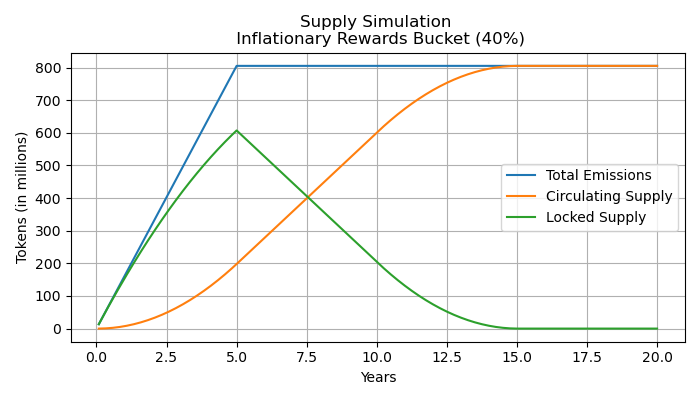

In [9]:
# Plotting
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, months_to_simulate + 1)/12, np.asarray(results['total'][-1])/1e6, label='Total Emissions')
plt.plot(np.arange(1, months_to_simulate + 1)/12, np.asarray(results['circulating'][-1])/1e6, label='Circulating Supply')
plt.plot(np.arange(1, months_to_simulate + 1)/12, np.asarray(results['locked'][-1])/1e6, label='Locked Supply')

plt.xlabel('Years')
plt.ylabel('Tokens (in millions)')
plt.title(f'Supply Simulation \n Inflationary Rewards Bucket (40%)')
plt.legend()
plt.grid(True)
plt.tight_layout()